<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/show_image_online_root.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code load ROOT, python 2 environment. Runs this part only the first time.

In [1]:
import sys
print (sys.version, get_ipython())
if 'google.colab' in str(get_ipython()) and sys.version[0:1] in '2':
  print('Running on CoLab')

  # istallazione di ROOT dal CERN
  !mkdir -p APPS
  !pwd
  !cd APPS && wget --no-check-certificate https://root.cern.ch/download/root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz 
  !cd APPS && tar -xf root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz

  base_lib_path = '/content/APPS/root/lib/'
  # main paths for ROOT  
  import sys
  sys.path.append(base_lib_path)
  import ctypes
  sys.path.append(base_lib_path)
  ctypes.cdll.LoadLibrary(base_lib_path+'libCore.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libThread.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libImt.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libRIO.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libNet.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libTree.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libMathCore.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libMatrix.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libHist.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libGraf.so')
  # itsllation and root-numpy main PATH
  !pip install root-numpy
  ctypes.cdll.LoadLibrary(base_lib_path+'libMultiProc.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libGpad.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libGraf3d.so')
  ctypes.cdll.LoadLibrary(base_lib_path+'libTreePlayer.so')
  # patch to open online FILE
  ! sudo apt-get install libdavix0v5
  ctypes.cdll.LoadLibrary(base_lib_path+'libRDAVIX.so')
  ! echo "Davix.GSI.CACheck: n" >> $ROOTSYS/etc/system.rootrc
  ! cp $ROOTSYS/etc/system.rootrc $HOME/.rootrc
  ! tail -1 $HOME/.rootrc
  ! pip install -q  python-swiftclient
  ! pip install -q  keystoneauth1
  ! pip install -q  h5py
  ! rm cygnus_lib.*; rm mylib.*
  ! wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/cygnus_lib.py
  ! wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/mylib.py
  sys.path.append('.')
  ! mkdir -p data
else:
  print ("non ho fatto nulla ;) non sono su Colab!")

('2.7.17 (default, Feb 27 2021, 15:10:58) \n[GCC 7.5.0]', <google.colab._shell.Shell object at 0x7fd684e7aa10>)
Running on CoLab
/content
--2021-03-09 12:50:22--  https://root.cern.ch/download/root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz
Resolving root.cern.ch (root.cern.ch)... 137.138.18.236, 2001:1458:201:ee::100:6
Connecting to root.cern.ch (root.cern.ch)|137.138.18.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137415272 (131M) [application/x-gzip]
Saving to: ‘root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz.2’

root_v6.13.08.Linux 100%[===================>] 131.05M  4.84MB/s    in 20s     

2021-03-09 12:50:44 (6.54 MB/s) - ‘root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz.2’ saved [137415272/137415272]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libdavix0v5 is already the newest version (0.6.7-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Davix.GSI.CACheck: n
--2021-03

richima paccehtti python per CYGNO


In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np    
import ROOT
import root_numpy as rtnp

import cygnus_lib as cy
import mylib as my
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from itertools import combinations
import math
import os

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
cy.set_atlas_style('square')

Welcome to JupyROOT 6.13/08


apere file [rum] from [tag] 

In [3]:
run = 2309
tag = "LAB" # Run tag: MAN, FNG, LAB, BTF, LTD
print ('Open file: '+cy.swift_root_file(tag, run))
f = ROOT.TFile.Open(cy.swift_root_file(tag, run))
# to download and open file
# f = cy.swift_read_root_file(cy.swift_root_file(tag, run))
# not useed anymore 
print ('Find Keys: '+str(len(f.GetListOfKeys())))
pic, wfm = cy.root_TH2_name(f)
max_image = len(pic)
max_wfm = len(wfm)
print ("# of Images (TH2) Files: {:d}".format(max_image))
print ("# of Waveform (TH2) Files: {:d} ".format(max_wfm))
image = rtnp.hist2array(f.Get(pic[0])).T
x_resolution = image.shape[1]
y_resolution = image.shape[0]
print ('Camera X, Y pixel: {:d} {:d} '.format(x_resolution, y_resolution))

Open file: https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/LAB/histograms_Run02309.root
Find Keys: 204
# of Images (TH2) Files: 102
# of Waveform (TH2) Files: 102 
Camera X, Y pixel: 2048 2048 


show imege file from [ini] to [end]

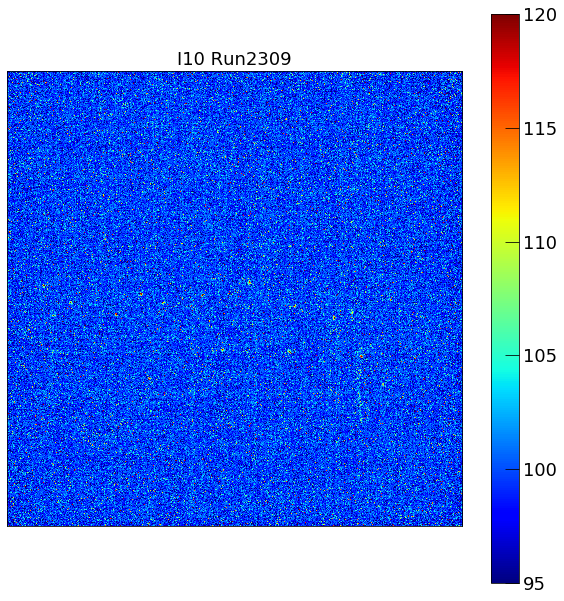

In [9]:
iTr = 10 # numero imagine da leggere
save = False
image = rtnp.hist2array(f.Get(pic[iTr])).T
fig = plt.figure(figsize=(10,10))
plt.title("I%d Run%d" % (iTr, int(run)))
plt.imshow(image,  cmap="jet", vmin=95,vmax=120)
plt.xticks([])
plt.yticks([])
plt.colorbar()
if save:
    plt.savefig('./images/I%dRun%s.png' % (iTr, run), format='png',  dpi = 400, bbox_inches = 'tight', pad_inches = 0)
plt.show()

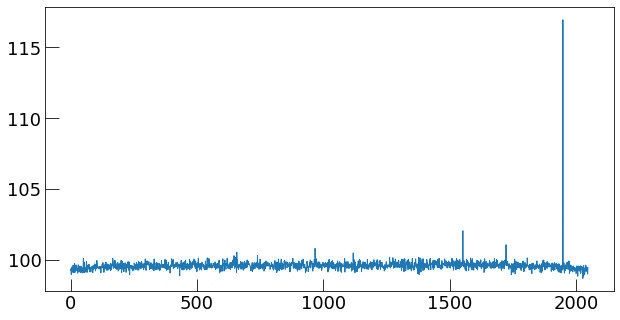

In [5]:
# esmpio di plot con python
y = np.mean(image, axis=0) # proizione imagine lungo le y
fig = plt.figure(figsize=(10,5))
x = np.linspace(0, y.size, y.size)
plt.plot(x,y)
plt.show()

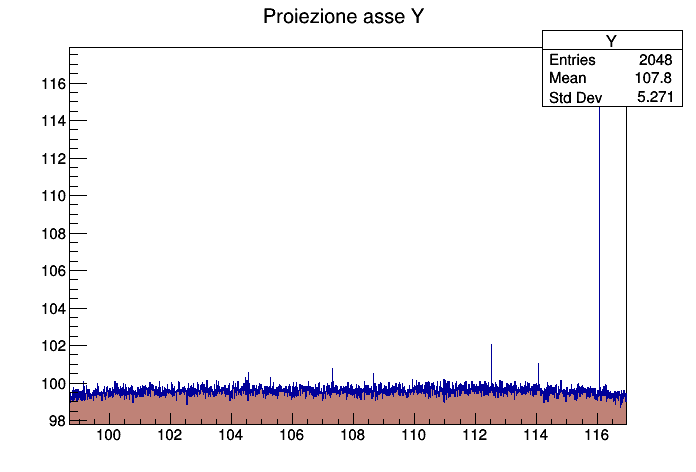

In [6]:
# esempio equvalente di plot con ROOT
c2 = ROOT.TCanvas( 'c2', 'Dynamic Filling Example', 200, 10, 700, 500 )
c2.SetFillColor( 0 )
c2.GetFrame().SetFillColor( 0 )
c2.GetFrame().SetBorderSize( 6 )
c2.GetFrame().SetBorderMode( -1 )
h = ROOT.TH1F("Y","Proiezione asse Y",np.size(y),np.min(y),np.max(y))
for i in range(np.size(y)):
   h.SetBinContent( i+1, y[i] )
#g = h.Fit( 'gaus')
#ROOT.gStyle.SetOptFit(1111)
h.Draw()
h.SetFillColor( 0 )
h.SetFillColor( 45 )
c2.Modified()
c2.Update()
c2.Draw()

 FCN=63.3148 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=1.72098e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.59265e+02   2.84172e+00   8.87614e-03  -1.21441e-05
   2  Mean         2.08421e-02   1.42133e-02   5.56466e-05  -2.24015e-03
   3  Sigma        9.90765e-01   1.08281e-02   1.13511e-05   5.64070e-03


Warning in <TDavixFile::Append>: Replacing existing TH1: gauss (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: myCanvasName


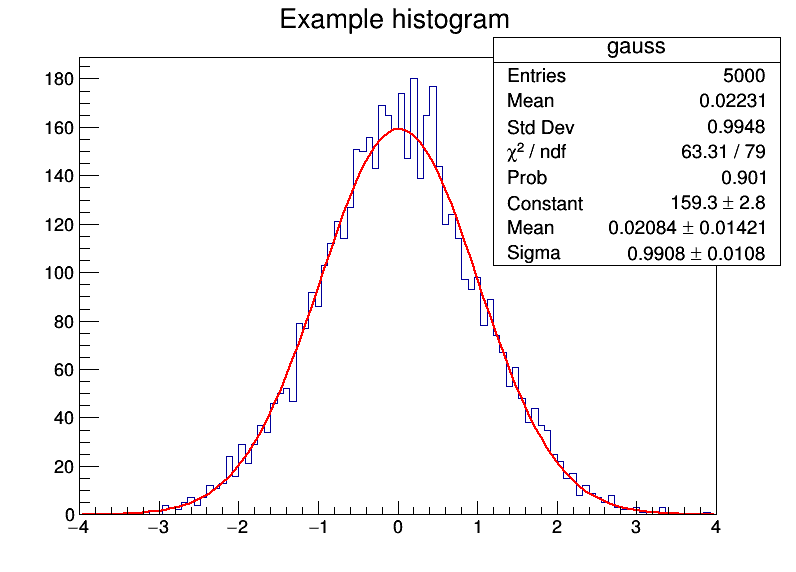

In [8]:
# esempio di fit con ROOT
import ROOT
h1 = ROOT.TH1F("gauss","Example histogram",100,-4,4)
h1.FillRandom("gaus")
c = ROOT.TCanvas("myCanvasName","The Canvas Title",800,600)
g = h1.Fit( 'gaus')
ROOT.gStyle.SetOptFit(1111)
h1.Draw()
c.Draw()
# esempi vari qui... https://root.cern.ch/doc/master/group__tutorial__pyroot.html (io ROOT non lo bazzico molto)